In [111]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import nltk
import tensorflow as tf
import keras
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

# https://medium.com/voice-tech-podcast/text-classification-using-cnn-9ade8155dfb9
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Embedding, Dropout, AveragePooling1D, BatchNormalization
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

In [112]:
keras.utils.set_random_seed(4248)

In [113]:
train_df = pd.read_json('train.jsonl', lines=True)
X_train = train_df['string']
y_train = train_df['label']

dev_df = pd.read_json('dev.jsonl', lines=True)
X_dev = dev_df['string']
y_dev = dev_df['label']

test_df = pd.read_json('test.jsonl', lines=True)
X_test = test_df['string']
y_test = test_df['label']

train_df

,source,citeEnd,sectionName,citeStart,string,label,label_confidence,citingPaperId,citedPaperId,isKeyCitation,id,unique_id,excerpt_index,label2,label2_confidence
0,explicit,175.0,Introduction,168.0,"However, how frataxin interacts with the Fe-S ...",background,1.0000,1872080baa7d30ec8fb87be9a65358cd3a7fb649,894be9b4ea46a5c422e81ef3c241072d4c73fdc0,True,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,11,NaN,NaN
1,explicit,36.0,Novel Quantitative Trait Loci for Seminal Root...,16.0,"In the study by Hickey et al. (2012), spikes w...",background,1.0000,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b,b6642e19efb8db5623b3cc4eef1c5822a6151107,True,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,2,NaN,NaN
2,explicit,228.0,Introduction,225.0,"The drug also reduces catecholamine secretion,...",background,1.0000,9cdf605beb1aa1078f235c4332b3024daa8b31dc,4e6a17fb8d7a3cada601d942e22eb5da6d01adbd,False,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,0,NaN,NaN
3,explicit,110.0,Discussion,46.0,By clustering with lowly aggressive close kin ...,background,1.0000,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,False,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,3,NaN,NaN
4,explicit,239.0,Discussion,234.0,Ophthalmic symptoms are rare manifestations of...,background,1.0000,88b86556857f4374842d2af2e359576806239175,a5bb0ff1a026944d2a47a155462959af2b8505a8,False,88b86556857f4374842d2af2e359576806239175>a5bb0...,88b86556857f4374842d2af2e359576806239175>a5bb0...,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8238,explicit,50.0,,28.0,"Importantly, the results of Pascalis et al. (2...",background,0.7350,6f68ccd37718366c40ae6aeedf0b935bf560b215,60ed4bdabf92b2fbd6162dbd8979888cccca55d7,True,6f68ccd37718366c40ae6aeedf0b935bf560b215>60ed4...,6f68ccd37718366c40ae6aeedf0b935bf560b215>60ed4...,15,NaN,NaN
8239,explicit,182.0,DISCUSSION,179.0,"As suggested by Nguena et al, there is a need ...",background,0.7508,f2a1c1704f9587c94ed95bc98179dc499e933f5e,574e659da7f6c62c07bfaaacd1f31d65bd75524c,True,f2a1c1704f9587c94ed95bc98179dc499e933f5e>574e6...,f2a1c1704f9587c94ed95bc98179dc499e933f5e>574e6...,1,NaN,NaN
8240,explicit,120.0,DISCUSSION,108.0,Skeletal muscle is also a primary site of dise...,background,1.0000,18c97ea2ff60c110cc2a523e0fdf729608cbb083,fc13b9c3dfcc121013edaa12fa8ce7842aaed21a,False,18c97ea2ff60c110cc2a523e0fdf729608cbb083>fc13b...,18c97ea2ff60c110cc2a523e0fdf729608cbb083>fc13b...,8,NaN,NaN
8241,explicit,221.0,,185.0,ACTIVATION OF TRANSCRIPTION FACTORS Roles for ...,method,NaN,4ec9b89857c0b27e8a4bd3745b7358f387773527,81affdba19e38e2b17cf7b9e93792cc2028cf21d,True,4ec9b89857c0b27e8a4bd3745b7358f387773527>81aff...,4ec9b89857c0b27e8a4bd3745b7358f387773527>81aff...,0,NaN,NaN


In [114]:
def cleaning(text):
    stop_words = stopwords.words('english')
    text = text.lower()
    text = ' '.join(x for x in text.split() if x not in stop_words)
    return text

In [115]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    words = []
    for x in text.split():
        x = lemmatizer.lemmatize(x)
        words.append(x)
    text = ' '.join(words)
    return text

In [116]:
def preprocessing(text):
    # Tokenization
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
    text = cleaning(text)
    text = lemmatize(text)
    text = ' '.join(tokenizer.tokenize(text))
    return text

In [117]:
def augment_data_multiclass(X, y):
    df = pd.concat([X, y], axis=1)
    majority_class_size = df['label'].value_counts().max()
    upsampled_dataframes = []
    for class_label in df['label'].unique():
        class_df = df[df['label'] == class_label]
        if len(class_df) < majority_class_size:
            class_df_upsampled = resample(class_df, replace=True, n_samples=majority_class_size, random_state=10)
            upsampled_dataframes.append(class_df_upsampled)
        else:
            upsampled_dataframes.append(class_df)
    upsampled_df = pd.concat(upsampled_dataframes)
    return upsampled_df['string'], upsampled_df['label']

In [118]:
# X_train, y_train = augment_data_multiclass(X_train, y_train)

In [119]:
X_train_preprocessed = X_train.apply(lambda x: preprocessing(x))
X_dev_preprocessed = X_dev.apply(lambda x: preprocessing(x))
X_test_preprocessed = X_test.apply(lambda x: preprocessing(x))

# Feature Extraction

In [120]:
# X_train, y_train = augment_data_multiclass(X_train, y_train)
# cv = CountVectorizer(ngram_range=(1,1), preprocessor=preprocessing, max_features=5000)
# X_train_bow = cv.fit_transform(X_train)
# X_dev_bow = cv.transform(X_dev)
# X_test_bow = cv.transform(X_test)

In [121]:
# #X_train, y_train = augment_data_multiclass(X_train, y_train)
# vectorizer = TfidfVectorizer(preprocessor=preprocessing, ngram_range=(1, 2), min_df=3, max_df=0.5, use_idf=True, smooth_idf=True,
#                              max_features=1000)
# X_train_tfidf = vectorizer.fit_transform(X_train)
# X_dev_tfidf = vectorizer.transform(X_dev)
# X_test_tfidf = vectorizer.transform(X_test)

In [122]:
num_words = 3000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

In [123]:
X_train_tokenized = tokenizer.texts_to_sequences(X_train_preprocessed)
X_dev_tokenized = tokenizer.texts_to_sequences(X_dev_preprocessed)
X_test_tokenized = tokenizer.texts_to_sequences(X_test_preprocessed)

# X_train_tokenized = tokenizer.texts_to_matrix(X_train_preprocessed)
# X_dev_tokenized = tokenizer.texts_to_matrix(X_dev_preprocessed)
# X_test_tokenized = tokenizer.texts_to_matrix(X_test_preprocessed)

# X_train_tokenized = X_train_tfidf
# X_dev_tokenized = X_dev_tfidf
# X_test_tokenized = X_test_tfidf

In [124]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

30596

In [125]:
initial_data = [X_train_tokenized, X_dev_tokenized, X_test_tokenized]
longest_length = -1
for dataset in initial_data:
    for arr in dataset:
        if len(arr) > longest_length:
            longest_length = len(arr)

longest_length

235

In [126]:
max_words = 250
X_train_padded = sequence.pad_sequences(X_train_tokenized, maxlen=max_words, padding='pre')
X_dev_padded = sequence.pad_sequences(X_dev_tokenized, maxlen=max_words, padding='pre')
X_test_padded = sequence.pad_sequences(X_test_tokenized, maxlen=max_words, padding='pre')

# Model

In [127]:
embeddings_dictionary = dict()
f = open('glove.6B/glove.6B.100d.txt', encoding="utf8")
for line in f.readlines():
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
f.close()

In [128]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.071953  ,  0.23127   ,  0.023731  , ..., -0.71894997,
         0.86894   ,  0.19539   ],
       ...,
       [-0.39030999, -0.083025  , -0.67050999, ..., -0.83982998,
         0.58714998, -0.13801999],
       [-0.33013999, -0.95363998, -0.51998001, ..., -0.35080999,
        -0.81892002, -0.023499  ],
       [ 0.19399001, -0.15526   , -0.37463999, ..., -0.12037   ,
         0.12235   , -0.067194  ]])

In [135]:
# Initializing CNN
model = Sequential()
# Dimensions for embedding? 
# https://medium.com/@matti.kwan/optimal-dimensions-for-word-embeddings-take-two-27b79e719699
# model.add(Embedding(num_words, 80, embeddings_regularizer=regularizers.l2(0.0005)))
model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=max_words, trainable=False))
# model.add(BatchNormalization())
model.add(Dropout(0.5, seed=4248))
# model.add(Embedding(num_words, 64, input_length=max_words))
model.add(Conv1D(80, 3, padding='same', activation='relu', bias_regularizer=regularizers.l2(0.0005), kernel_regularizer=regularizers.l2(0.0005)))
model.add(MaxPooling1D())
# model.add(Conv1D(150, 3, padding='same', activation='relu', bias_regularizer=regularizers.l2(0.0005), kernel_regularizer=regularizers.l2(0.0005)))
# model.add(MaxPooling1D())
# model.add(Conv1D(32, 3, padding='same', activation='linear'))
# model.add(Conv1D(64, 3, padding='same', activation='sigmoid'))
# model.add(Conv1D(64, 3, padding='same', activation='relu'))
# model.add(Conv1D(128, 3, padding='same', activation='relu'))
# model.add(Conv1D(32, 3, padding='same', activation='tanh'))
# model.add(AveragePooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)))
model.add(Dropout(0.4, seed=4248))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'f1_score', 'precision', 'recall'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 250, 100)          3059600   
                                                                 
 dropout_20 (Dropout)        (None, 250, 100)          0         
                                                                 
 conv1d_14 (Conv1D)          (None, 250, 80)           24080     
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 125, 80)           0         
 ng1D)                                                           
                                                                 
 flatten_10 (Flatten)        (None, 10000)             0         
                                                                 
 dense_20 (Dense)            (None, 250)               2500250   
                                                     

In [136]:
classes = y_train.unique().tolist()

y_train_int = y_train.apply(func=lambda x: classes.index(x))
y_dev_int = y_dev.apply(func=lambda x: classes.index(x))
y_test_int = y_test.apply(func=lambda x: classes.index(x))

print(y_train_int.dtype)
print(y_dev_int.dtype)
print(y_test_int.dtype)

int64
int64
int64


In [137]:
history = model.fit(X_train_padded, 
          y_train_int, 
          validation_data=(X_dev_padded, y_dev_int), 
          epochs=20, 
          batch_size=128, 
          verbose=2)

# history = model.fit(X_train_tfidf.toarray(), 
#           y_train_int, 
#           validation_data=(X_dev_tfidf.toarray(), y_dev_int), 
#           epochs=5, 
#           batch_size=128, 
#           verbose=2)

Epoch 1/20
65/65 - 13s - loss: 0.8153 - accuracy: 0.4487 - val_loss: 0.6934 - val_accuracy: 0.4323 - 13s/epoch - 193ms/step
Epoch 2/20
65/65 - 10s - loss: 0.5730 - accuracy: 0.5286 - val_loss: 0.4998 - val_accuracy: 0.5666 - 10s/epoch - 152ms/step
Epoch 3/20
65/65 - 11s - loss: 0.4321 - accuracy: 0.5511 - val_loss: 0.3340 - val_accuracy: 0.5426 - 11s/epoch - 166ms/step
Epoch 4/20
65/65 - 11s - loss: 0.1628 - accuracy: 0.5561 - val_loss: -3.9326e-02 - val_accuracy: 0.5360 - 11s/epoch - 176ms/step
Epoch 5/20
65/65 - 11s - loss: -9.7791e-01 - accuracy: 0.5511 - val_loss: -2.0152e+00 - val_accuracy: 0.5895 - 11s/epoch - 174ms/step
Epoch 6/20
65/65 - 12s - loss: -3.8636e+00 - accuracy: 0.5504 - val_loss: -7.0972e+00 - val_accuracy: 0.5579 - 12s/epoch - 179ms/step
Epoch 7/20
65/65 - 12s - loss: -1.3015e+01 - accuracy: 0.5523 - val_loss: -1.8719e+01 - val_accuracy: 0.5448 - 12s/epoch - 179ms/step
Epoch 8/20
65/65 - 12s - loss: -3.3106e+01 - accuracy: 0.5350 - val_loss: -4.1439e+01 - val_accur

In [138]:
scores = model.evaluate(X_test_padded, y_test_int)
# scores = model.evaluate(X_test_tfidf.toarray(), y_test_int)

# MaxLen    Epochs  Accuracy                Details
# 1000      25      53.78828644752502%      No Preprocess, batch_size=128, verbose=2
# 1000      2       53.036004304885864%     No Preprocess, batch_size=128, verbose=2
# 1000      50      52.82106399536133%      No Preprocess, batch_size=128, verbose=2
# 1000      5       53.788286447525024%     Preprocess, batch_size=128, verbose=2
# 1000      5       49.758195877075195%     Preprocess, batch_size=128, verbose=2, Embedding output_dim = 64
# 1000      5       50.56421160697937%      Preprocess, batch_size=128, verbose=2, Embedding output_dim = 64, Conv1d(64, 32), Dropout(0.3), Conv1d(32,3)
# 1000      5       32.50940442085266%      Preprocess, batch_size=128, verbose=2, TfIdfVectorizer
# 1000      5       51.7463743686676%       Preprocess, batch_size=128, verbose=2, Padding="Post"
# 1000      5       49.32831823825836%      Preprocess, batch_size=128, verbose=2, Padding="Post", add conv1d 64 and conv1d 128 after conv1d 32
# 1000      5       49.865663051605225%     Preprocess, batch_size=128, verbose=2, add conv1d 64 and conv1d 128 after conv1d 32
# 1000      10      51.37023329734802%      Preprocess, batch_size=128, verbose=2, add conv1d 64 and conv1d 128 after conv1d 32
# 1000      10      32%                     Preprocess, batch_size=32, verbose=2, add conv1d 64 and conv1d 128 after conv1d 32
# 1000      10      52.76733040809631%      Preprocess, batch_size=128, verbose=2, add dense(100) below dense(250)
# 1000      10      53.84202003479004%      Preprocess, batch_size=128, verbose=2
print(f"Accuracy: {scores[1] * 100}%")
# print(f"F1 Score: {scores[2] * 100}%")
# print(f"Recall: {scores[3] * 100}%")
# print(f"Precision: {scores[4] * 100}%")

59/59 [==============================] - 1s 19ms/step - loss: -1322.1432 - accuracy: 0.5304
Accuracy: 53.036004304885864%


In [139]:
# With reference to https://realpython.com/python-keras-text-classification/#your-first-keras-model
# Plotting histogram
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

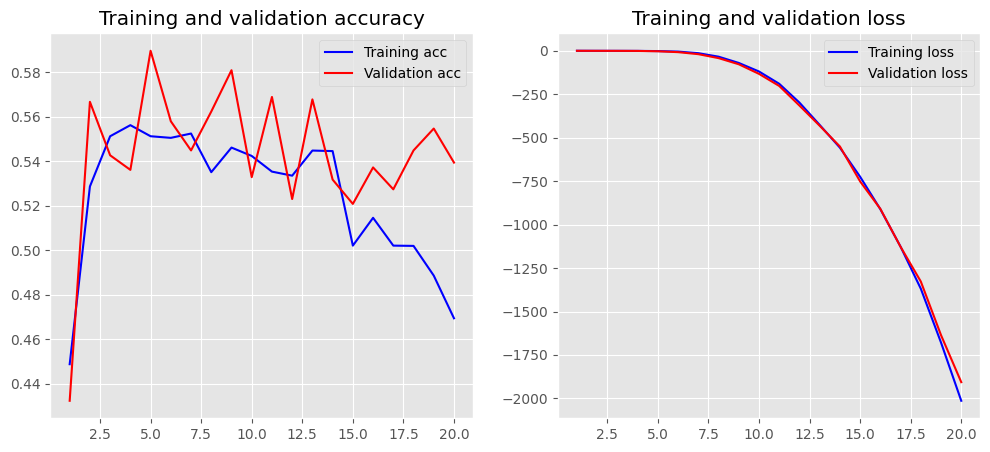

In [140]:
plot_history(history)
# history.history